In [1]:
# let's train a model combining BT and BSL
# Training data is august and test is september, missing a day so 
#  its pretty much half and half

In [2]:
# Standard imports

import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas


from ml_common import zscale, scale, print_metrics


In [3]:
base = "/data/nature_run/work/data/"
dirs = [base+x for x in os.listdir(base) if "bsl_cpl532_bt_72sigma_" in x]
dirs = sorted(dirs)
for x in dirs:
    print(x)

/data/nature_run/work/data/bsl_cpl532_bt_72sigma_h1_labels.npz
/data/nature_run/work/data/bsl_cpl532_bt_72sigma_ha_labels.npz
/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hb_labels.npz
/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hc_labels.npz
/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hd_labels.npz
/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hw_labels.npz
/data/nature_run/work/data/bsl_cpl532_bt_72sigma_mh_labels.npz


In [ ]:
# dirs = ["/data/nature_run/work/data/bsl_cpl532_bt_72sigma_mh_labels.npz",
#         "/data/nature_run/work/data/bsl_cpl532_bt_72sigma_ha_labels.npz",
#         "/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hb_labels.npz",
#         "/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hc_labels.npz",
#         "/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hd_labels.npz",
#         "/data/nature_run/work/data/bsl_cpl532_bt_72sigma_hw_labels.npz"]

In [4]:

bt_data = []
bs_data = []
labels_scalar = []
labels_table = []

for n, i in enumerate(dirs):
    data = np.load(i)
    print(data["bs_data"].shape, data["labels_tables"].shape)
    bt_data.append(data["bt_data"])
    bs_data.append(data["bs_data"])
    labels_scalar.append(data["labels_scalars"])
    labels_table.append(data["labels_tables"])
    


(1797073, 733) (1797073, 72, 5)
(1797073, 733) (1797073, 72, 5)
(1797073, 733) (1797073, 72, 5)
(1797073, 733) (1797073, 72, 5)
(1797073, 733) (1797073, 72, 5)
(1797073, 733) (1797073, 72, 5)
(1797073, 733) (1797073, 72, 5)


In [ ]:
# h1 is not in hympi but lets get it anyway
#data = np.load("/data/nature_run/work/data/bsl_cpl532_bt_72sigma_h1_labels.npz")
#h1_data = data["bt_data"]
#labels_scalar.append(data["labels_scalars"])
#print(h1_data.shape)
#print(len(labels_scalar))

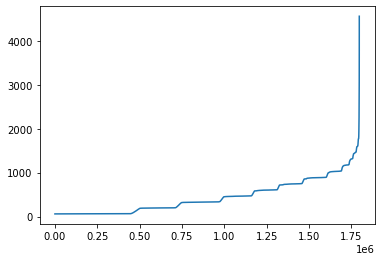

In [6]:
plt.plot(sorted(labels_scalar[6][:,0]))

In [7]:
bands = []
for n, i in enumerate(dirs):
    band = i.split("_")[5]
    bands.append(band)
print(bands)

['h1', 'ha', 'hb', 'hc', 'hd', 'hw', 'mh']


In [12]:
print(bands)
bands_d = {}
for n, i in enumerate(bands):
    bands_d[i] = n
print(bands_d)

['h1', 'ha', 'hb', 'hc', 'hd', 'hw', 'mh']
{'h1': 0, 'ha': 1, 'hb': 2, 'hc': 3, 'hd': 4, 'hw': 5, 'mh': 6}


In [8]:
for n, i in enumerate(bands):
    print(i, bt_data[n].shape)

h1 (1797073, 480)
ha (1797073, 482)
hb (1797073, 461)
hc (1797073, 504)
hd (1797073, 509)
hw (1797073, 22)
mh (1797073, 22)


In [9]:
# Get indexs for data run
with open("/home/jmackin1/Projects/pbl/HyMPI_channel_selection.txt") as fp:
    data = [x.strip().split() for x in fp.readlines()]

indices = []
for n, i in enumerate(data):
    if n == 0:
        start = []
        start.append(int(i[0]))
    elif len(i) > 2:
        indices.append(start)
        start = []
        start.append(int(i[0]))
    else:
        start.append(int(i[0]))
indices.append(start)

# Shift values are from the word doc HyMPI Channel Discussion 1.2.docx
shift = [1, 503, 985, 1446, 1950, 2459]

indices_shifted = []
for n, i in enumerate(indices):
    indices_shifted.append([x - shift[n] for x in i])

In [13]:
# indices for cosmir-h
# 50 - 58 GHz; 175 - 191 GHz; 89GHz, 165.5 GHz

# shift including h1
shift_wh1 = {"mh":1, "h1":22, "ha":503, "hb":985, "hc":1446, "hd":1950, "hw":2459}

# H1 50-53 Ghz 0.5 step
h1_ch_sub = np.r_[103:110] - shift_wh1["h1"]

# HA 52.6-57.30
ha_ch_sub = np.r_[514:985] - shift_wh1["ha"]

# HD 175-191
hd_ch_sub = np.r_[1998:2396] - shift_wh1["hd"]

# 89
hw_89 = np.r_[2470:2471] - shift_wh1["hw"]

# 165.6
hw_165 = np.r_[2475:2476] - shift_wh1["hw"]


h1_data_ch_sub =  bt_data[bands_d["h1"]][:, h1_ch_sub]
ha_data_ch_sub =  bt_data[bands_d["ha"]][:, ha_ch_sub]
hd_data_ch_sub =  bt_data[bands_d["hd"]][:, hd_ch_sub]
hw_data_ch1_sub = bt_data[bands_d["hw"]][:, hw_89]
hw_data_ch2_sub = bt_data[bands_d["hw"]][:, hw_165]

ch_data = np.hstack((h1_data_ch_sub,ha_data_ch_sub,hd_data_ch_sub,hw_data_ch1_sub,hw_data_ch2_sub))
print(ch_data.shape)

(1797073, 878)


In [ ]:
#plus 23 31 - 

In [15]:

hsel = np.zeros((bt_data[0].shape[0], 1957))
print(hsel.shape)

(1797073, 1957)


In [16]:

mh_data_sub = bt_data[bands_d["mh"]][:, indices_shifted[0]]
ha_data_sub = bt_data[bands_d["ha"]][:, indices_shifted[1]]
hb_data_sub = bt_data[bands_d["hb"]][:, indices_shifted[2]]
hc_data_sub = bt_data[bands_d["hc"]][:, indices_shifted[3]]
hd_data_sub = bt_data[bands_d["hd"]][:, indices_shifted[4]]
hw_data_sub = bt_data[bands_d["hw"]][:, indices_shifted[5]]


In [17]:
a = 0
ind = []
for i in [1, 471, 461, 501, 501, 22]:
    ind.append(np.r_[a:a+i])
    a+=i 


In [18]:

# print(hsel_train)
# print(hsel_test)
hsel[:, ind[0]] = mh_data_sub
hsel[:, ind[1]] = ha_data_sub
hsel[:, ind[2]] = hb_data_sub
hsel[:, ind[3]] = hc_data_sub
hsel[:, ind[4]] = hd_data_sub
hsel[:, ind[5]] = hw_data_sub

print(hsel)

[[235.6146 251.3532 251.5387 ... 269.214  270.5413 272.7777]
 [235.6409 251.3745 251.56   ... 269.0473 270.3909 272.6622]
 [235.6869 251.4135 251.5989 ... 268.8151 270.1741 272.4784]
 ...
 [245.9386 260.6384 260.8258 ... 284.9347 284.7863 284.2987]
 [246.0448 260.6875 260.8745 ... 284.9781 284.8223 284.3244]
 [245.8775 260.6167 260.8045 ... 284.9369 284.8027 284.3366]]


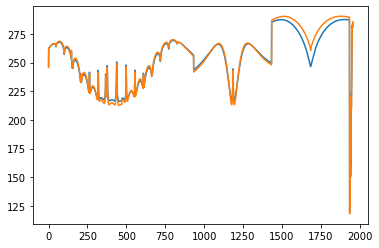

In [19]:
plt.plot(hsel[102000])
plt.plot(hsel[120000])
plt.show()

In [20]:
np.all(bs_data[0] == bs_data[1])


True

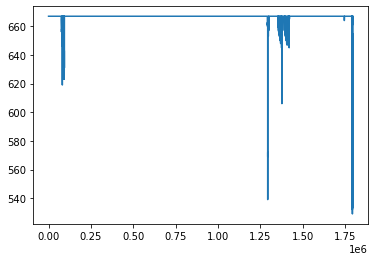

In [21]:
mins = []
for i in bs_data[0]:
    mins.append(int(np.argwhere(i == -.00001)[0]))
bs_depth = np.array(mins)

plt.plot(bs_depth)


# mins = []
# for i in x_test_bsl_raw[0]:
#     mins.append(int(np.argwhere(i == -.00001)[0]))
# bs_depth_test = np.array(mins)

# plt.plot(bs_depth_test)
plt.show()


In [22]:
print(bs_depth.shape)

(1797073,)


In [23]:
for i in labels_scalar:
    print(i.shape)
    
print(np.all(labels_scalar[0] == labels_scalar[6]))
print(np.all(labels_table[0] == labels_table[1]))


(1797073, 6)
(1797073, 6)
(1797073, 6)
(1797073, 6)
(1797073, 6)
(1797073, 6)
(1797073, 6)
True
True


In [25]:

nfo = {'ha': "Eleven channels from Roger Aires’ list, plus 471 hyperspectral channels on the lower frequency wing of the temperature band;52.6GHz to 57.3 GHz",
       'hb': "After a gap, continue with 461 hyperspectral channels down the other side of the temperature line. This is the region Matt McLinden hopes to use on his instrument;63.3GHz to 67.9Ghz",
       'hc': "3 more Aires channels, then 501 hyperspectral channels in the 118 GHz temperature sounding region;113.7GHz to 123.7",
       'hd': "3 Aires channels, 501 hyperspectral water channels, 5 Aires channels;173.3Ghz to 193.3",
       'hw': "The Aires channels over again, all together",
       'h1': "evenly spaced from 10Ghz to 250Ghz",
       'ch': "cosimir-h bands",
       'hs': "hsel, the proposed collection of bands for HyMPI",
       'hs_indices': {'info': "these indices are what makes up hsel/hs", 'indices': indices_shifted},
       'bs': "Back scatter lidar, nans filled to -0.00001",
       'bs_depth': "Index of 'ground' level, ie where -0.00001 values start",
       'labels_scalar': "pblh, lat, lon, surface_pressure, surface_pressure, date and time",
       'labels_table': "P, height_above_sea_level, temp, water_vapor, ozone_density"
}
pickle.dump(nfo, open("data/bt_bslcpl532_all_72sigma_v2_meta.pkl", 'wb'))

In [27]:
np.savez("data/bt_bslcpl532_all_72sigma_v2.npz", ha=bt_data[bands_d["ha"]],
                                                 hw=bt_data[bands_d["hw"]],
                                                 hd=bt_data[bands_d["hd"]],
                                                 mh=bt_data[bands_d["mh"]],
                                                 hc=bt_data[bands_d["hc"]],
                                                 h1=bt_data[bands_d["h1"]],
                                                 hb=bt_data[bands_d["hb"]],
                                                 ch=ch_data,
                                                 hs=hsel,
                                                 bs=bs_data[0],
                                                 bs_depth=bs_depth,
                                                 labels_scalar=labels_scalar[6],
                                                 labels_table=labels_table[0])

In [ ]:
# look at some of the data
print(x_train_bt_raw.shape)
print_metrics(x_train_bsl_raw[0,:])
print(np.sum(x_train_bsl_raw2),np.sum(x_train_bsl_raw))

In [ ]:
print(min(bs_depth_train))
np.argwhere(bs_depth_train==min(bs_depth_train))

In [ ]:

print(x_train_bsl_raw.shape)

#show = np.r_[600:667]

# plt.plot(x_train_bsl_raw[0,600:667])
# plt.plot(x_train_bsl_raw[205000,600:667])
# plt.plot(x_train_bsl_raw[305000,600:667])
# plt.plot(x_train_bsl_raw[405000,600:667])
# plt.plot(x_train_bsl_raw[615000,600:667])
# plt.plot(x_train_bsl_raw[615001,600:667])
# plt.show()

#plt.plot(x_train_bsl_raw[0,:])
plt.plot(x_train_bsl_raw[501442,:])
plt.plot(x_train_bsl_raw[81573,:])
#plt.plot(x_train_bsl_raw[205000,:])
#plt.plot(x_train_bsl_raw[305000,:])
#plt.plot(x_train_bsl_raw[405000,:])
#plt.plot(x_train_bsl_raw[615000,:])
#plt.plot(x_train_bsl_raw[615001,:])
plt.show()

In [ ]:
interesting = np.r_[600:667]
gold = x_train_bsl_raw[0, interesting]
errors = np.zeros((x_train_bsl_raw.shape[0]))
for n, i in enumerate(x_train_bsl_raw):
    cur = i[interesting]
    # mean squared error
    errors[n] = np.sum((gold - cur)**2)/gold.shape[0]
    

In [ ]:
plt.plot(errors)
plt.show()

In [ ]:
pblh_train = y_train_raw[:,0]
pblh_test  = y_test_raw[:,0]

indices_train = np.argwhere(pblh_train>200)
indices_test = np.argwhere(pblh_test>200)

print(indices_train.shape, y_train_raw.shape)
print(indices_train)

In [ ]:
# Scale data
# How to deal with lowest value? 
# zscale bsl is wrong, per band makes no sense 

x_train_bt = zscale(x_train_bt_raw[indices_train])
x_train_bsl = zscale_simple(x_train_bsl_raw[indices_train])
y_train, train_metrics = scale(y_train_raw[indices_train,0], metrics=True)
latlon_train = y_train_raw[indices_train,1:3]


x_test_bt = zscale(x_test_bt_raw[indices_test])
x_test_bsl = zscale_simple(x_test_bsl_raw[indices_test])
y_test, test_metrics = scale(y_test_raw[indices_test,0], metrics=True)
latlon_test = y_test_raw[indices_test,1:3]


print(x_train_bt.shape, x_train_bsl.shape, y_train.shape)

In [ ]:
np.savez("data/bsl_bt_hw_labels_scaled.npz", 
         x_train_bt=x_train_bt,
         x_train_bsl=x_train_bsl,
         y_train=y_train,
         y_train_raw=y_train_raw[indices_train],
         latlon_train=latlon_train,
         bs_depth_train=bs_depth_train,
         indices_train=indices_train,
         train_metrics=train_metrics,
         x_test_bt=x_test_bt,
         x_test_bsl=x_test_bsl,
         y_test=y_test,
         y_test_raw=y_test_raw[indices_test],
         latlon_test=latlon_test,
         bs_depth_test=bs_depth_test,
         indices_test=indices_test,
         test_metrics=test_metrics)
         

In [ ]:
tmpavg = avg = np.average(x_train_bsl_raw, axis=0)
print(tmpavg.shape)

In [ ]:
print(x_train_bt.shape)
print(x_train_bsl.shape)

print_metrics(x_train_bt)
print_metrics(x_train_bsl)
print(metrics)